In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer


In [140]:
HEADING_LIST = ['h1','h2','h3','h4','h5','h6']
EMPHASISED_LIST = ['strong','b','a', 'blockquote', 'cite', 'em','i','mark','q','pre','u']

webpage_data = pd.read_csv("webpages.csv", low_memory=False, encoding = "ISO-8859-1")
tags =  list(webpage_data.Tag)
urls =  list(webpage_data.URL)
sentences =  list(webpage_data.Sentence)
y_true = list(webpage_data.TrueValue)
webpage_list = list(zip(urls, sentences, tags, y_true))

https://blog.heartsupport.com/a-letter-to-my-daughter-about-young-men-2bab2fca4971
i 18303
A Letter to My Daughter About YoungMen
i 18304
A Letter to My Daughter About YoungMen
i 18305
My dearest Adelaide,
i 18306
My dearest Adelaide,
i 18307
One day you will ask me
i 18308
Daddy, what was the war like?
i 18309
Daddy, what was the war like?
i 18310
and I will freeze like a deer caught in the headlights
i 18311
How should I answer a question like that?
i 18312
How should I answer a question like that?
i 18313
I wonder
i 18314
 Especially to a young girl, curious about what shes learned in school
i 18315
Daddy was in the war
i 18316
 Both of them
i 18317
 I see his medals in our hallway!
i 18318
Daddy was in the war
i 18319
 Both of them
i 18320
 I see his medals in our hallway!
i 18321
Perhaps this is what youll tell your teacher
i 18322
 But as you grow into a teenager youll have more questions, and I imagine I will be somewhat of an enigma at times
i 18323
So instead I will tell you a

i 19145
/conference/blog post/
i 19146
TED talk
i 19147
TED talk
i 19148
roduct Hunt
i 19149
roduct Hunt
i 19150
Thanks for reading
i 19151
 I hope this helps my fellow designers out there
i 19152
Thanks for reading
i 19153
 I hope this helps my fellow designers out there
i 19154
Shoutout to
i 19155
Krishen Kotecha
i 19156
Krishen Kotecha
i 19157
for inspiring this post and putting up with my sarcasm in general
i 19158
Never miss a story from
i 19159
, when you sign up for Medium
i 19160
Learn more
i 19161
Learn more
i 19162
Never miss a story from
i 19163
Get updates
i 19164
Get updates
i 19165
Get updates
i 19166
Get updates
https://hackernoon.com/how-it-feels-to-learn-javascript-in-2016-d3a717dd577f
i 12089
How it feels to learn JavaScript in2016
i 12090
How it feels to learn JavaScript in2016
i 12091
No JavaScript frameworks were created during the writing of this article
i 12092
No JavaScript frameworks were created during the writing of this article
i 12093
No JavaScript framewor

i 12660
 Another one?
i 12661
Err, doesnt ring a bell
i 12662
 Another one?
i 12663
#NAME?
i 12664
#NAME?
i 12665
#NAME?
i 12666
Another one?
i 12667
Another one?
i 12668
#NAME?
i 12669
#NAME?
i 12670
#NAME?
i 12671
 Are there similar to that last one?
i 12672
 Are there similar to that last one?
i 12673
-Mustache, underscore? I think now even lodash has one to be honest, but those are kind of 2014
i 12674
-Mustache, underscore? I think now even lodash has one to be honest, but those are kind of 2014
i 12675
-Mustache, underscore? I think now even lodash has one to be honest, but those are kind of 2014
i 12676
 maybe it was newer
i 12677
 maybe it was newer
i 12678
#NAME?
i 12679
#NAME?
i 12680
#NAME?
i 12681
#NAME?
i 12682
#NAME?
i 12683
#NAME?
i 12684
#NAME?
i 12685
#NAME?
i 12686
#NAME?
i 12687
#NAME?
i 12688
 Jade?
i 12689
#NAME?
i 12690
 Jade?
i 12691
#NAME?
i 12692
 Jade?
i 12693
No, you already said Jade
i 12694
No, you already said Jade
i 12695
#NAME?
i 12696
 I meant Jade
i 12

one goddamn day
i 12986
one goddamn day
i 12987
in November
i 12988
Oh but what about your eeeemaaaaillls??? Shut the fuck up
i 12989
 Seriously, shut the fuck up and listen for one fucking second
i 12990
Oh but what about your eeeemaaaaillls??? Shut the fuck up
i 12991
 Seriously, shut the fuck up and listen for one fucking second
i 12992
Heres all you need to know about me:
i 12993
Heres all you need to know about me:
i 12994
In 1992, I said I was proud to have followed my career instead of baking cookies
i 12995
In 1992, I said I was proud to have followed my career instead of baking cookies
i 12996
The GOP
i 12997
fucking dragged me
i 12998
fucking dragged me
i 12999
for it
i 13000
 They
i 13001
made me bake cookies
i 13002
made me bake cookies
i 13003
 Theyre
i 13004
scared of me
i 13005
scared of me
i 13006
Every time I have a job, yall love me
i 13007
 Every time I run for anything, the GOP breaks out the big guns again and fucks me up good
i 13008
 And apparently it fucking wor

i 13719
Get updates
https://medium.com/an-idea-for-you/the-two-minutes-it-takes-to-read-this-will-improve-your-writing-forever-82a7d01441d1
i 11994
The Two Minutes It Takes To Read This Will Improve Your WritingForever
i 11995
The Two Minutes It Takes To Read This Will Improve Your WritingForever
i 11996
Each week I share helpful ideas in my
i 11997
Each week I share helpful ideas in my
i 11998
10 Ideas Worth Sharing
i 11999
10 Ideas Worth Sharing
i 12000
10 Ideas Worth Sharing
i 12001
Sign up here
i 12002
Sign up here
i 12003
Sign up here
i 12004
to get next weeks ideas
i 12005
to get next weeks ideas
i 12006
Youre busy, so Ill keep this quick
i 12007
Youre busy, so Ill keep this quick
i 12008
Following are the simplest tips I can give you to easilyand foreverimprove the quality of your writing
i 12009
Following are the simplest tips I can give you to easilyand foreverimprove the quality of your writing
i 12010
Delete the wordthat
i 12011
Delete the wordthat
i 12012
At least 90% of th

In contrast, heres a weird product with no sex appeal which had no prior user adoption to build on and that was doomed to fail from the outset, no matter
i 19394
how many models showed up for the fashion walks
i 19395
how many models showed up for the fashion walks
i 19396
You can buy fashionable friends, and you can pay them to wear your stuff to make some photos, but you cant get them to choose to wear what youre offering in their real lives unless theres a bridge to the familiar, essential, and down-to-earth
i 19397
You can buy fashionable friends, and you can pay them to wear your stuff to make some photos, but you cant get them to choose to wear what youre offering in their real lives unless theres a bridge to the familiar, essential, and down-to-earth
i 19398
AirPods build on the success of the iPod, which is related to the story of Napster and taking on the record industry, saying
i 19399
Fuck you!
i 19400
Fuck you!
i 19401
to Metallica (
i 19402
especially to Lars
i 19403
espec

i 9743
DOWNLOAD HERE
i 9744
DOWNLOAD HERE
i 9745
DOWNLOAD HERE
i 9746
DOWNLOAD HERE
i 9747
If you dig this article, please hit recommend below
i 9748
 Thanks!:)
i 9749
If you dig this article, please hit recommend below
i 9750
 Thanks!:)
i 9751
Never miss a story from
i 9752
The Mission
i 9753
The Mission
i 9754
, when you sign up for Medium
i 9755
Learn more
i 9756
Learn more
i 9757
Never miss a story from
i 9758
The Mission
i 9759
The Mission
i 9760
Get updates
i 9761
Get updates
i 9762
Get updates
i 9763
Get updates
https://medium.com/p/1df945c09ac6
i 4706
A Teenagers View on SocialMedia
i 4707
A Teenagers View on SocialMedia
i 4708
Written by an actualteen
i 4709
Written by an actualteen
i 4710
I read technology
i 4711
I read technology
i 4712
articles quite often and see plenty of authors attempt to dissect or describe the teenage audience, especially in regards to social media
i 4713
 However, I have yet to see a teenager contribute their voice to this discussion
i 4714
 This is 

i 1476
 Waiting, being patient, and trusting that life will slowly inch along and things will eventually get better
i 1477
 After all, change takes time
i 1478
But time is all it takes
i 1479
But time is all it takes
i 1480
) NO FRUIT JUICE
i 1481
) NO FRUIT JUICE
i 1482
) NO FRUIT JUICE
i 1483
Never miss a story from
i 1484
Aaron Bleyaert
i 1485
Aaron Bleyaert
i 1486
, when you sign up for Medium
i 1487
Learn more
i 1488
Learn more
i 1489
Never miss a story from
i 1490
Aaron Bleyaert
i 1491
Aaron Bleyaert
i 1492
Get updates
i 1493
Get updates
https://medium.com/p/263ab694e60e
i 6139
UI / UXTrends
i 6140
UI / UXTrends
i 6141
Whether on an app screen, a web browser, or a wearable watch face, design is one of the most important drivers of consumer engagement
i 6142
 From flat design to Material design, I analysed what trends have evolved, and share a few of my insights with youwhat are these trends? Why are they beneficial to the user? And how are they created?
i 6143
Whether on an app s

i 7442
 Tests that are not graded on a bell curve or by percentages; tests that are graded by one simple stipulation: survival!
i 7443
Because I could pass your tests if I had to, but you couldnt stand for a single second in the face of the tests that life has thrown me
i 7444
 Tests that are not graded on a bell curve or by percentages; tests that are graded by one simple stipulation: survival!
i 7445
4:: Because You DontRead
i 7446
4:: Because You DontRead
i 7447
Because you read the things you are required to read or nothing at all
i 7448
Because you read the things you are required to read or nothing at all
i 7449
Because you think history is boring and philosophy is stupid
i 7450
Because you think history is boring and philosophy is stupid
i 7451
Because you would rather sit and watch E! or MTV instead of exploring something new, instead of diving head first, into the brain of another man in an attempt to better understand the world around you
i 7452
Because you would rather sit a

 When a powerful websitesay Google or Facebookgazes at, or links to, another webpage, it doesnt just connect itit brings it into existence; gives it life
i 7736
 Metaphorically, without this empowering gaze, your web page doesnt breathe
i 7737
 No matter how many links you have placed in a webpage, unless somebody is looking at it, it is actually both dead
i 7738
blind; and therefore incapable of transferring power to any outside web page
i 7739
On the other hand, the most powerful web pages are those that have many eyes upon them
i 7740
 Just like celebrities who draw a kind of power from the millions of human eyes gazing at them any given time, web pages can capture and distribute their power through hyperlinks
i 7741
On the other hand, the most powerful web pages are those that have many eyes upon them
i 7742
 Just like celebrities who draw a kind of power from the millions of human eyes gazing at them any given time, web pages can capture and distribute their power through hyperlin

i 6867
 Youll snap or warp or splinter if you ask too much
i 6868
 You have a limited capacity to direct yourself a certain way
i 6869
 Its worth considering where that directive capacity goes every day
i 6870
Run, wherever you are
i 6871
Run, wherever you are
i 6872
Running is the best way to reset, to overcome jetlag, to see a new place and to feel good about the world
i 6873
Listen to your body
i 6874
Listen to your body
i 6875
 You might feel like youve found a loophole, but if youre not honest, your body will catch up with you soon enough
i 6876
Control your inputs
i 6877
Control your inputs
i 6878
 Not just what you eat and drink (though this will have a profound impact), control what you read, what you watch, what you listen to, what notifications you allow on your phone, where you spend your time, who you spend it with
i 6879
 Guard your gates with care
i 6880
Everyone has a vice
i 6881
Everyone has a vice
i 6882
 To err is human
i 6883
 Everyone has a fault-line
i 6884
 Dont s

i 10306
 Each of you is able to see when things are not done well
i 10307
 Certainly we all complain enough about other peoples software, and we all know how important first impressions are in our own judgements
i 10308
 That is exactly how others will evaluate us
i 10309
Putting yourself in the mind of someone who is coming to Slack for the first timeespecially a real someone, who is being made to try this thing by their boss, who is already a bit hangry because they didnt have time for breakfast, and who is anxious about finishing off a project before they take off for the long weekendputting yourself in their mind means looking at Slack the way you look at some random piece of software in which you have no investment and no special interest
i 10310
 Look at it hard, and find the things that do not work
i 10311
 Be harsh, in the interest of being excellent
i 10312
Putting yourself in the mind of someone who is coming to Slack for the first timeespecially a real someone, who is being 

Black and white first
i 5281
Black and white first
i 5282
Black and white first
i 5283
Double your whitespace
i 5284
Double your whitespace
i 5285
Double your whitespace
i 5286
Learn the methods of overlaying text on images
i 5287
Learn the methods of overlaying text on images
i 5288
Part 2
i 5289
Part 2
i 5290
Make text pop and un-pop
i 5291
Make text pop and un-pop
i 5292
Only use good fonts
i 5293
Only use good fonts
i 5294
Steal like an artist
i 5295
Steal like an artist
i 5296
Lets get to it
i 5297
Lets get to it
i 5298
Rule 1: Light Comes From theSky
i 5299
Rule 1: Light Comes From theSky
i 5300
Shadows are invaluable cues in telling the human brain what user interface elements were looking at
i 5301
Shadows are invaluable cues in telling the human brain what user interface elements were looking at
i 5302
Shadows are invaluable cues in telling the human brain what user interface elements were looking at
i 5303
This is perhaps the
i 5304
most important non-obvious thing
i 5305
mos

i 2679
, and had tested out the many copycat products that had come out over the years
i 2680
 I felt the problem had already been solved
i 2681
 It was a crowded market and knew it would be difficult to make his product stand out from the crowd
i 2682
 Regardless, I was excited to get a chance to work with Stewart, and thought it would be fun to solve some of the issues that wed had with Campfire
i 2683
 We shook hands, kicked things off, and rolled up our sleeves
i 2684
When he pulled back the curtain and shared their early prototype on day one, it looked like a hacked together version of IRC in the browser
i 2685
 Barebones and stark
i 2686
 Just six weeks later, we had done some of the best work of our careers
i 2687
 So, how did we get from hacky browser IRC to the Slack we all know and love?
i 2688
When he pulled back the curtain and shared their early prototype on day one, it looked like a hacked together version of IRC in the browser
i 2689
 Barebones and stark
i 2690
 Just six

 Instead, we appended a simple @Sonar to content that users shared from our app
i 11329
 Although we had designs for a map, we never got around to building one
i 11330
 We were too busy building the future of ambient social networking!
i 11331
 People
i 11332
didnt like
i 11333
didnt like
i 11334
the bland @Sonar text string so they stopped sharing updates from Sonar
i 11335
 Their friends never engaged with our updates in the first place
i 11336
 Facebook noticed this and started hiding our posts
i 11337
 Instead of optimizing for actual user behavior, we spent countless whiteboarding sessions trying in vain to design an alternative
i 11338
Lesson learned:
i 11339
Lesson learned:
i 11340
Lesson learned:
i 11341
Lesson learned:
i 11342
You are probably not the Steve Jobs of ______
i 11343
You are probably not the Steve Jobs of ______
i 11344
Removing friction from existing user behaviors (e
i 11345
 checkins) almost always has a higher ROI than building castles in the sky (e
i 11346
 h

i 10635
You could make something right now
i 10636
 If you wanted to stop reading, grab a sheet of butchers paper and brainstorm ideas, you could probably come up with half a dozen ideas for apps, books or products
i 10637
 Ideas arent the hard part, after alljust ask Tom Haverford
i 10638
You could build a Wordpress site and start harassing your friends to test the concept
i 10639
 You could start writing op-ed pieces on Medium and put Founder or Author in your Twitter bio within 48 hours
i 10640
 You could throw up a landing page, post the first chapter of a book and start pushing it on Product Hunt
i 10641
You could build a Wordpress site and start harassing your friends to test the concept
i 10642
 You could start writing op-ed pieces on Medium and put Founder or Author in your Twitter bio within 48 hours
i 10643
 You could throw up a landing page, post the first chapter of a book and start pushing it on Product Hunt
i 10644
Where things get tough is when youre trying to make somet

i 2053
If you feel a knot in your stomach because you can see the enormous distance between your dreams and your daily reality, do one thing to tighten your grip on what you wanttoday
i 2054
If you feel a knot in your stomach because you can see the enormous distance between your dreams and your daily reality, do one thing to tighten your grip on what you wanttoday
i 2055
If youve been peering out over the edge of the cliff but cant quite make the leap, dig a little deeper and find out whats stopping youtoday
i 2056
If youve been peering out over the edge of the cliff but cant quite make the leap, dig a little deeper and find out whats stopping youtoday
i 2057
Because there is a recurring choice in life, and it occurs at the intersection of two roads
i 2058
 We arrive at this place again and again
i 2059
 And today, you get to choose
i 2060
Because there is a recurring choice in life, and it occurs at the intersection of two roads
i 2061
 We arrive at this place again and again
i 2062


The Message
i 6020
, when you sign up for Medium
i 6021
Learn more
i 6022
Learn more
i 6023
Never miss a story from
i 6024
The Message
i 6025
The Message
i 6026
Get updates
i 6027
Get updates
i 6028
Get updates
i 6029
Get updates
https://medium.com/p/9eba5eef2976
i 4605
I Had a Baby and Cancer When I Worked at Amazon
i 4606
 This Is MyStory
i 4607
I Had a Baby and Cancer When I Worked at Amazon
i 4608
 This Is MyStory
i 4609
Last Saturday, I read the 6,000-word
i 4610
New York Times
i 4611
New York Times
i 4612
Inside Amazon
i 4613
Inside Amazon
i 4614
, in the car on my way to the beach
i 4615
 I sat quietly in the front seat, glued to my phone while my husband flapped his hand gesturing for help with Google maps
i 4616
 My two-year-old danced to the sounds of Raffi in the back
i 4617
 When we got to the beach, we set up our spot, complete with dinosaur sand toys
i 4618
 My husband and daughter made a beeline for the water
i 4619
 I put on my Coolibar SPF 50 jacket to cover my skin fr

i 976
Most of us say yes more often than we should because it is so much easier than saying no
i 977
 Nobody wants to be the bad guy
i 978
Most of us say yes more often than we should because it is so much easier than saying no
i 979
 Nobody wants to be the bad guy
i 980
In a
i 981
2012 study
i 982
2012 study
i 983
published in the Journal of Consumer Research, researchers split 120 students in 2 groups
i 984
 One group was trained to use I cant, while the other was trained to use I dont
i 985
 The results were interesting:
i 986
The students who told themselves I cant eat X chose to eat the chocolate candy bar 61% of the time
i 987
 Meanwhile, the students who told themselves I dont eat X chose to eat the chocolate candy bars only 36% of the time
i 988
 This simple change in terminology significantly improved the odds that each person would make a more healthy food choice
i 989
The students who told themselves I cant eat X chose to eat the chocolate candy bar 61% of the time
i 990
 Me

i 1562
 Its not helping you get better at anything
i 1563
5) Career
i 1564
5) Career
i 1565
Do not take that corporate job
i 1566
 Just dont do it (
i 1567
see point 2
i 1568
see point 2
i 1569
6) Trust
i 1570
6) Trust
i 1571
Even if it kills your relationships
i 1572
 Even if it destroys your ideas
i 1573
 Even if you lose your friends
i 1574
 Even if it means you end up getting hurt
i 1575
Even if it kills your relationships
i 1576
 Even if it destroys your ideas
i 1577
 Even if you lose your friends
i 1578
 Even if it means you end up getting hurt
i 1579
Trust people until they give you a reason notto
i 1580
Trust people until they give you a reason notto
i 1581
Trust people until they give you a reason notto
i 1582
But dont be nave
i 1583
 Some people are out to fuck you
i 1584
But dont be nave
i 1585
 Some people are out to fuck you
i 1586
7) People
i 1587
7) People
i 1588
People are the best and worst thing that will happen to you
i 1589
 Some will help you go further, faster
i 1

i 5168
Symbols Matter
i 5169
Symbols Matter
i 5170
As a result of this project, Im on high alert for symbolism
i 5171
 I try to question all icons, especially those that feel the most familiar
i 5172
 For example, is the briefcase the best symbol for work? Which population carried briefcases and in which era? What are other ways that work could be symbolized and what would those icons evoke for the majority of people on Earth?
i 5173
As a result of this project, Im on high alert for symbolism
i 5174
 I try to question all icons, especially those that feel the most familiar
i 5175
 For example, is the briefcase the best symbol for work? Which population carried briefcases and in which era? What are other ways that work could be symbolized and what would those icons evoke for the majority of people on Earth?
i 5176
All those good intentions I met on the first day were real
i 5177
 We all want to continue to make Facebook the best it can be, to have culture of doing rather than complainin

i 3713
All The Free Stock:
i 3714
All The Free Stock:
i 3715
Free stock images, icons, and videos
i 3716
Free stock images, icons, and videos
i 3717
Free (do whatever you want) high-resolution photos
i 3718
Free (do whatever you want) high-resolution photos
i 3719
Search & discover free, hi res photos & videos
i 3720
Search & discover free, hi res photos & videos
i 3721
Startup Stock Photos:
i 3722
Startup Stock Photos:
i 3723
Startup Stock Photos:
i 3724
 Make something
i 3725
 Make something
i 3726
Jay Mantri:
i 3727
Jay Mantri:
i 3728
Jay Mantri:
i 3729
Free pics
i 3730
 do anything (CC0)
i 3731
 Make magic
i 3732
Free pics
i 3733
 do anything (CC0)
i 3734
 Make magic
i 3735
This is a journey of a portuguese guy moving east
i 3736
This is a journey of a portuguese guy moving east
i 3737
Travel Coffee Book:
i 3738
Travel Coffee Book:
i 3739
Travel Coffee Book:
i 3740
Sharing beautiful travel moments
i 3741
Sharing beautiful travel moments
i 3742
Designers Pics:
i 3743
Designers Pics:

i 4517
 Only a few of them really matter
i 4518
 (Yes, its hard to know which
i 4519
) Dont get distracted
i 4520
Say no to most things: Features
i 4521
 People
i 4522
 Partnerships
i 4523
 Coffees
i 4524
 Projects
i 4525
 Only a few of them really matter
i 4526
 (Yes, its hard to know which
i 4527
) Dont get distracted
i 4528
Take Care ofYourself
i 4529
Take Care ofYourself
i 4530
When you dont sleep, eat crap, dont exercise, and are living off adrenaline for too long, your performance suffers
i 4531
 Your decisions suffer
i 4532
 Your companysuffers
i 4533
When you dont sleep, eat crap, dont exercise, and are living off adrenaline for too long, your performance suffers
i 4534
 Your decisions suffer
i 4535
 Your companysuffers
i 4536
Love those Close toYou
i 4537
Love those Close toYou
i 4538
Failure of your company is not failure in life
i 4539
 Failure in your relationships is
i 4540
Failure of your company is not failure in life
i 4541
 Failure in your relationships is
i 4542
Never

 I dont know if its a boy or a girl
i 2505
 Im just a corpse, Im not a fortune teller
i 2506
Now youll understand what real love is, son
i 2507
 Youll realize how much you love her, but real love is something youll feel for this little thing over there
i 2508
 I dont know if its a boy or a girl
i 2509
 Im just a corpse, Im not a fortune teller
i 2510
Now youll understand what real love is, son
i 2511
 Youll realize how much you love her, but real love is something youll feel for this little thing over there
i 2512
 I dont know if its a boy or a girl
i 2513
 Im just a corpse, Im not a fortune teller
i 2514
Have fun
i 2515
 Its a great thing
i 2516
 Time is gonna fly now, so make sure youll be around
i 2517
 Never miss a moment, they never come back
i 2518
 Change diapers, bathe the baby, be a role model to this child
i 2519
 I think you have what it takes to be an amazing father, just like me
i 2520
Have fun
i 2521
 Its a great thing
i 2522
 Time is gonna fly now, so make sure youll be 

i 19493
 Im disappointed because the decision is a symptom of a larger problem that is eating the web
i 19494
Over the past few decades a significant portion of the economy has shifted
i 19495
 Once upon a time companies and services were geared toward enticing you out of your money
i 19496
 Today, the goal of many is to entice you out of your time
i 19497
 Which, in turn, is leveraged as collateral to attract money from advertisers
i 19498
Over the past few decades a significant portion of the economy has shifted
i 19499
 Once upon a time companies and services were geared toward enticing you out of your money
i 19500
 Today, the goal of many is to entice you out of your time
i 19501
 Which, in turn, is leveraged as collateral to attract money from advertisers
i 19502
Our current version of the internet lives and breathes off a currency of human attention
i 19503
 With the success and failure of many internet companies predicated on how much of a persons time they can capture
i 19504


i 15693
The Credit Karma of LinkedIn
i 15694
The Credit Karma of LinkedIn
i 15695
My first day of work was July 5th
i 15696
 I walked into the office to find 17 employees
i 15697
 Between June and July, the startup hired an additional 9 members, including a young social media manager who had been running marketing efforts free range prior to my arrival
i 15698
 I had notated in my interview keynote that this person was a team member that I would fill as Marketing Director, so it was interesting they decided to hire the person without communicating with me
i 15699
 Even more interesting was the fact that she labeled herself as the Chief Marketing Officer of the startup on her social media channels before she even met me
i 15700
 Already there were signs pointing to challenges ahead
i 15701
My first day of work was July 5th
i 15702
 I walked into the office to find 17 employees
i 15703
 Between June and July, the startup hired an additional 9 members, including a young social media manag

As I mentioned earlier, this means more and more of your favorite apps are going to start looking like one another
i 19854
 Why? Much like the NFL, tech is a copycat league
i 19855
 These redesigns were met with generally positive reviews (some people are complaining about a lack of personality in these new black and white UIs but theyll soon get over that
i 19856
 You open an app for its functionality, not its personality) so I expect apps both new and old to start jumping on the CR bandwagon
i 19857
As I mentioned earlier, this means more and more of your favorite apps are going to start looking like one another
i 19858
 Why? Much like the NFL, tech is a copycat league
i 19859
 These redesigns were met with generally positive reviews (some people are complaining about a lack of personality in these new black and white UIs but theyll soon get over that
i 19860
 You open an app for its functionality, not its personality) so I expect apps both new and old to start jumping on the CR band

to whats underneath
i 13225
Apps and websites sprinkle intermittent variable rewards all over their products because its good for business
i 13226
Apps and websites sprinkle intermittent variable rewards all over their products because its good for business
i 13227
But in other cases, slot machines emerge by accident
i 13228
 For example, there is no malicious corporation behind
i 13229
all of email
i 13230
all of email
i 13231
who consciously chose to make it a slot machine
i 13232
 No one profits when millions check their email and nothings there
i 13233
 Neither did Apple and Googles designers
i 13234
phones to work like slot machines
i 13235
 It emerged by accident
i 13236
But now companies like Apple and Google have a responsibility to reduce these effects by
i 13237
converting intermittent variable rewards into less addictive, more predictable ones
i 13238
converting intermittent variable rewards into less addictive, more predictable ones
i 13239
with better design
i 13240
 For e

You can learn something from these
i 18557
 Trustme
i 18558
Im a collector of quotes
i 18559
 I love it when I can find a phrase, a sentence, a particular grouping of words that can change my perspective, open my fucking eyes, and spread a little light for me
i 18560
Im a collector of quotes
i 18561
 I love it when I can find a phrase, a sentence, a particular grouping of words that can change my perspective, open my fucking eyes, and spread a little light for me
i 18562
I read, constantly
i 18563
 Its the most important thing you can ever do with your time, because its an opportunity to tap into the collected knowledge of the entirety of human historywhile sitting on the couch
i 18564
I read, constantly
i 18565
 Its the most important thing you can ever do with your time, because its an opportunity to tap into the collected knowledge of the entirety of human historywhile sitting on the couch
i 18566
These are 10 quotes that Ive picked up along the way
i 18567
 They have a lot of meani

 I also use fasting to get spiritual clarity and refinement
i 14335
Fasting is also one of the most recognized techniques in religious and spiritual practices
i 14336
 I also use fasting to get spiritual clarity and refinement
i 14337
Honestly, I could go on for hours about this one
i 14338
 Give it a try
i 14339
 Youll never be the same
i 14340
Honestly, I could go on for hours about this one
i 14341
 Give it a try
i 14342
 Youll never be the same
i 14343
 Fast from the internet 24 hours once perweek
i 14344
 Fast from the internet 24 hours once perweek
i 14345
Your body gets an intervention when you fast
i 14346
 Your mind and relationships could use one too
i 14347
 Unplug yourself from the matrix
i 14348
Your body gets an intervention when you fast
i 14349
 Your mind and relationships could use one too
i 14350
 Unplug yourself from the matrix
i 14351
If you havent caught on already, human beings are highly addictive creatures
i 14352
We love our coffee, sugar, and internet
i 14353


Success Magazine
i 14725
Success Magazine
i 14726
, Tim Ferriss said that he doesnt have five or ten year goals
i 14727
 Instead, he works on experiments or projects for a 612 week period of time
i 14728
 If they do extremely well, the possible doors that could open are endless
i 14729
 Tim would rather play to the best possibilities than get stuck on one track
i 14730
 He says this approach allows him to go drastically farther than he could ever plan for
i 14731
 Remove all non-essentials from your life (start with yourcloset)
i 14732
 Remove all non-essentials from your life (start with yourcloset)
i 14733
You cannot overestimate the unimportance of practically everything
i 14734
Greg McKeown
i 14735
You cannot overestimate the unimportance of practically everything
i 14736
Greg McKeown
i 14737
Most of the possessions you own, you dont use
i 14738
 Most of the clothes in your closet, you dont wear
i 14739
 Get rid of them
i 14740
 They are sucking energy from your life
i 14741
 Also,

i 15187
Instead, he invests in banking and insurance
i 15188
 Hes not a tech guy
i 15189
 He invests in what he understands
i 15190
Yet, so many people invest in things they dont understand
i 15191
 Ive made that mistake
i 15192
 I once invested several thousand dollars in an overseas rice distribution
i 15193
 Although the investment sounded incredible on paper, its turned out to be a disaster
i 15194
Yet, so many people invest in things they dont understand
i 15195
 Ive made that mistake
i 15196
 I once invested several thousand dollars in an overseas rice distribution
i 15197
 Although the investment sounded incredible on paper, its turned out to be a disaster
i 15198
I didnt have the understanding to make an informed decision
i 15199
 I put my trust in someone elses hands
i 15200
 And no one cares about your success more than you do
i 15201
I didnt have the understanding to make an informed decision
i 15202
 I put my trust in someone elses hands
i 15203
 And no one cares about your

 Take A ColdShower
i 656
 Take A ColdShower
i 657
 Take A ColdShower
i 658
Tony Robbins starts every morning by jumping into a 57-degree Fahrenheit swimming pool
i 659
Tony Robbins starts every morning by jumping into a 57-degree Fahrenheit swimming pool
i 660
Why would he do such a thing?
i 661
Why would he do such a thing?
i 662
Cold water immersion radically facilitates physical and mental wellness
i 663
 When practiced regularly, it provides long-lasting changes to your bodys immune, lymphatic, circulatory and digestive systems that improve the quality of your life
i 664
 It can also increase weight-loss because it boosts your metabolism
i 665
Cold water immersion radically facilitates physical and mental wellness
i 666
 When practiced regularly, it provides long-lasting changes to your bodys immune, lymphatic, circulatory and digestive systems that improve the quality of your life
i 667
 It can also increase weight-loss because it boosts your metabolism
i 668
2007 research study
i

i 18540
The Mission
i 18541
The Mission
i 18542
, when you sign up for Medium
i 18543
Learn more
i 18544
Learn more
i 18545
Never miss a story from
i 18546
The Mission
i 18547
The Mission
i 18548
Get updates
i 18549
Get updates
i 18550
Get updates
i 18551
Get updates
https://medium.com/the-mission/the-greatest-sales-deck-ive-ever-seen-4f4ef3391ba0
i 16477
The Greatest Sales Deck Ive EverSeen
i 16478
The Greatest Sales Deck Ive EverSeen
i 16479
Its Zuoras, and its brilliant
i 16480
 Hereswhy
i 16481
Its Zuoras, and its brilliant
i 16482
 Hereswhy
i 16483
A few months ago, my friend Tim took a new sales job at a Series C tech company that had raised over $60 million from A-list investors
i 16484
 Hes one of the best salespeople I know, but soon after starting, he emailed me to say he was struggling
i 16485
A few months ago, my friend Tim took a new sales job at a Series C tech company that had raised over $60 million from A-list investors
i 16486
 Hes one of the best salespeople I know, 

 I love the coffee and the environment here
i 13830
I work in Fashion Public Relations
i 13831
 Im pitching stories for a client and working on areport
i 13832
I work in Fashion Public Relations
i 13833
 Im pitching stories for a client and working on areport
i 13834
I work in Fashion Public Relations
i 13835
 Im pitching stories for a client and working on areport
i 13836
I work in Fashion Public Relations
i 13837
 Im pitching stories for a client and working on areport
i 13838
Im studying palm-reading history in my free time
i 13839
 Im a writer and do teacher tutoring
i 13840
 I try not to work at home because of all the potential distractions
i 13841
Im studying palm-reading history in my free time
i 13842
 Im a writer and do teacher tutoring
i 13843
 I try not to work at home because of all the potential distractions
i 13844
Im studying palm-reading history in my free time
i 13845
 Im a writer and do teacher tutoring
i 13846
 I try not to work at home because of all the potential 

i 18060
I enjoy being uncompromising in setting goals for myself
i 18061
 I get great satisfaction from knowing that I can regularly set myself a personal challenge and attack it daily
i 18062
 Whether I accomplish what I set out to achieve, only I know
i 18063
I enjoy being uncompromising in setting goals for myself
i 18064
 I get great satisfaction from knowing that I can regularly set myself a personal challenge and attack it daily
i 18065
 Whether I accomplish what I set out to achieve, only I know
i 18066
Playing Tetris every day builds my determination, my focus, my will to persevere at things I know have no conclusion
i 18067
And I dont play to winI play to play
i 18068
And I dont play to winI play to play
i 18069
We should all be playing life to play
i 18070
 We shouldnt only see our enemies or seek to control
i 18071
We should all be playing life to play
i 18072
 We shouldnt only see our enemies or seek to control
i 18073
We must understand that this is simply a matter of pers

Ill still be here when you get back
i 18181
Tip #2: Encrypt your harddrive
i 18182
Tip #2: Encrypt your harddrive
i 18183
have built-in full-disk encryption
i 18184
 You just need to turn it on
i 18185
Tip #3: Turn on your phones password protection
i 18186
Tip #3: Turn on your phones password protection
i 18187
Thumbprint identification is better than nothing, but its often not enough
i 18188
Thumbprint identification is better than nothing, but its often not enough
i 18189
The fifth amendment (against self-incrimination) allows you to keep your password secret
i 18190
 But a court can compel you to unlock your phone with your thumbprint
i 18191
The fifth amendment (against self-incrimination) allows you to keep your password secret
i 18192
 But a court can compel you to unlock your phone with your thumbprint
i 18193
Also, you cant exactly change your thumbprint after an attacker gets ahold of it
i 18194
Also, you cant exactly change your thumbprint after an attacker gets ahold of it


In [151]:
from collections import Counter
from itertools import chain
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1]))
    return vocab, vocabcount

In [152]:
vocab, vocabcount = get_vocab(sentences)


In [153]:
print(vocab[:50])
print('...',len(vocab))

TypeError: 'map' object is not subscriptable

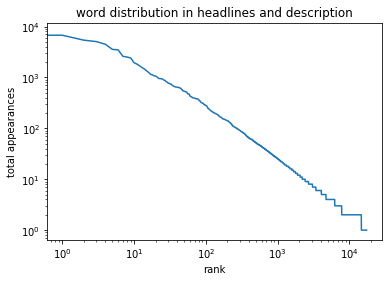

In [154]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([vocabcount[w] for w in vocab]);
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.title('word distribution in headlines and description')
plt.xlabel('rank')
plt.ylabel('total appearances');

In [125]:
train, test = train_test_split(webpage_list, test_size = 0.33, random_state = 49)


In [162]:
train


[('https://medium.com/swlh/how-technology-hijacks-peoples-minds-from-a-magician-and-google-s-design-ethicist-56d62ef5edf3',
  'conscious choice',
  nan,
  0.091836735000000003),
 ('https://medium.com/p/8dc34fbe592b',
  'GE CEO Jeff Immelt wakes up at 5:30am and gets in a cardio workout while reading the paper and watching CNBC',
  nan,
  0.27397260299999998),
 ('https://medium.com/the-mission/50-ways-happier-healthier-and-more-successful-people-live-on-their-own-terms-31ba8f482448',
  'Heres a tip if youre just starting out: start your shower warm, as usual',
  nan,
  0.23134328399999998),
 ('https://medium.com/p/a988c17383a6',
  ' The more perfectionistic the professor, the less productive they are, Dr',
  nan,
  0.33175355499999998),
 ('https://medium.com/the-mission/50-ways-happier-healthier-and-more-successful-people-live-on-their-own-terms-31ba8f482448',
  ' Stop pretending youll live forever',
  nan,
  0.19512195100000002),
 ('https://medium.com/@thatdavidhopkins/how-a-tv-sitcom-

In [4]:
X_train = [sentence for url, sentence, tag, ytrue in train]
Y_train = np.array([ytrue for url, sentence, tag, ytrue in train], dtype = 'float')
X_test = [sentence for url, sentence, tag, ytrue in test]
Y_test = np.array([ytrue for url, sentence, tag, ytrue in test], dtype = 'float')
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(13532, 10443)

In [20]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(13532, 10443)

In [25]:

is_emphasised = np.array([1 if tag in EMPHASISED_LIST else 0 for url, sentence, tag, y_label in train])
is_heading = np.array([1 if tag in HEADING_LIST else 0 for url, sentence, tag, y_label in train])
is_title = np.array([1 if tag == 'title' else 0 for url, sentence, tag, y_label in train])
features = np.column_stack((is_heading, is_emphasised, is_title))
features.shape

(13532, 3)

In [13]:
from scipy.sparse import coo_matrix, hstack
A = coo_matrix(X_train_tfidf)
B = coo_matrix(features)
C =hstack([A,B])
C.shape
Y_train.shape

C.shape

(13532, 10446)

In [10]:
X_tests_counts = count_vect.transform(X_test)
X_tests_tfidf = tfidf_transformer.transform(X_tests_counts)
X_tests_counts.shape

(6666, 10443)

In [11]:
X_tests_tfidf = tfidf_transformer.transform(X_tests_counts)
X_tests_tfidf.shape

(6666, 10443)

In [28]:
is_emphasised_test = np.array([1 if tag in EMPHASISED_LIST else 0 for url, sentence, tag, y_label in test])
is_heading_test = np.array([1 if tag in HEADING_LIST else 0 for url, sentence, tag, y_label in test])
is_title_test = np.array([1 if tag == 'title' else 0 for url, sentence, tag, y_label in test])
features_test = np.column_stack((is_heading_test, is_emphasised_test, is_title_test))
features_test.shape

D = coo_matrix(X_tests_tfidf)
E = coo_matrix(features_test)
F =hstack([D,E])
F.shape

(6666, 10446)

In [29]:
from sklearn import linear_model                                                                                                                                              

lin = linear_model.LinearRegression() #initialize regressor                                                                                                                   

lin.fit(C, Y_train) #fit training data                                                                                                                                  
preds = lin.predict(F) #make prediction on X test set   

In [30]:
len(preds)

6666

In [35]:
from sklearn import metrics    
from sklearn.metrics import mean_squared_error, r2_score
print('Mean Absolute Error: \n',metrics.mean_absolute_error(Y_test, preds, multioutput='uniform_average')) #evaluate performance 

# The coefficients
print('Coefficients: \n', lin.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, preds))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_test, preds))

Mean Absolute Error: 
 0.0963000117927
Coefficients: 
 [ 0.41695143  0.07709095 -0.27087183 ..., -0.00284868 -0.0095109   0.        ]
Mean squared error: 0.04
Variance score: -0.77


In [ ]:
def featurizer(train):
    # create your list that will soon be a list of tuples - there is a tuple for each movie which contains 
    # a dictionary of the movie's features and its genre tag
    total_feature_set = []
    true_labels = []

    # loop through the movies in the training set
    for url, sentence, tag, y_label in train:
        # for each movie, create a dictionary that will hold its features
        feature_dict = {}
        # loop through vocabulary and mark if each word is present or not (Boolean)
        
        feature_dict['is_heading'] = 1 if tag in HEADING_LIST else 0
        feature_dict['is_emphasised'] = 1 if tag in EMPHASISED_LIST else 0
        feature_dict['is_title'] = 1 if tag == 'title' else 0

        total_feature_set.append([feature_dict['is_heading'], feature_dict['is_emphasised'], feature_dict['is_title']])
        #append it all to the main feature set
        true_labels.append(y_label)
        
    return (total_feature_set, true_labels)

In [ ]:
title_list = []
for url, sentence, tag, y_label in train:
    if tag == 'h1':
        title_list.append(sentence)
title_list

In [ ]:

training_features, true_labels = featurizer(train)
len(training_features)
true_labels[0:10]

In [170]:
df = pd.DataFrame(test, columns=['URL', 'Sentence', 'Tag', 'TrueValue'])
sentences_test =  list(df.Sentence)

url_group = df.groupby(['URL'])

url_group

In [179]:
cur_url = test[0][0]
cur_max = 0.0
best_sentence = ''
dict_final = {}
print(cur_url)
for i in range(0, len(test)):
    if cur_url == test[i][0]:
        if cur_max < preds[i]:
            cur_max = preds[i]
            best_sentence = test[i][1]
    else:
        cur_max = max(preds[i], 0.0)
        dict_final[cur_url] = (best_sentence, cur_max)
        best_sentence = test[i][1]
        cur_url = test[i][0]

dict_final
len(dict_final.keys())


#G = webpage_data.groupby('URL')['TrueValue'].apply(list)
# import heapq, random
# for val in G.values():
#     print(val)
#     print(heapq.nlargest(3, val))
#webpage_data.head()
dict_url = {}
for key, val in url_group.groups.items():
    sentence_prob = []
    for i in val:
        #print ('i', i)
        #print(sentences[i])
        sentence_prob.append((sentences_test[i], preds[i]))
    sentence_prob = sorted(sentence_prob, key=lambda x: x[1], reverse= True)
    #print(sentence_prob[:5])
    dict_url[key] = ''.join(sentence for sentence, prob in sentence_prob[:5])

print (dict_url)

https://medium.com/p/83486f42118c
{'https://blog.heartsupport.com/a-letter-to-my-daughter-about-young-men-2bab2fca4971': 'The laughter died, and the men stared blankly into their beers for a long moment, refusing to look at the man who had defied them, while he glared, daring them to challenge him Like jackals running wild, you do not want to be left alone to hunt, for fear that the pack may turn and devour you Instead, observe how he treats others, your waiter, the homeless, and the marginalized Instead, observe how he treats others, your waiter, the homeless, and the marginalized Other men would brave bullets and death to save an injured friend', 'https://blog.prototypr.io/the-ideal-design-workflow-2c200b8e337d': 'Come back from lunch and realize your Framer trial has expired Youve earned it)every great design begins on paperYour next step is to take photos of your sketches on your smart phone and throw those babies intoRealize Principle exports as a f***ing video? and give up for a 

In [ ]:
true_summaries = pd.read_csv("truesummaries.csv", low_memory=False, encoding = "ISO-8859-1")
true_vals =  list(true_summaries.TrueValue)
urls =  list(true_summaries.URL)
true_vals[:10]
len(urls)

In [ ]:
import nltk
for index, url in enumerate(urls):
    pred_summary = dict_url[url]
    actual_summary = true_summaries.loc[true_summaries['URL'] == url, 'TrueValue'].iloc[0]
    print(url)
    print('PRED', pred_summary)
    print('ACTUAL',actual_summary)
    BLEUscore = nltk.translate.bleu_score.sentence_bleu([actual_summary.split()], pred_summary.split())
    print (BLEUscore)